# Author: Yoonhyuck WOO / JBNU_Industrial Information system Engineering
# Date; 4. 8. 2022 - 4. 10. 2022
# Title: English_NER (conll03 data)
#  Professor: Seung-Hoon Na

In [1]:
from torch import cuda

device = 'cuda' if cuda.is_available() else 'cpu'

print(device)

cuda


In [2]:
pip install transformers

     |████████████████████████████████| 4.0 MB 6.5 MB/s 
     |████████████████████████████████| 596 kB 47.8 MB/s 
     |████████████████████████████████| 6.5 MB 59.1 MB/s 
     |████████████████████████████████| 77 kB 3.3 MB/s 
     |████████████████████████████████| 895 kB 50.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import os
import json
import numpy as np
from functools import partial
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel, FlaubertModel
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import re
import codecs
import pandas as pd

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Data Preprocess

In [5]:
def read_data(fn, column_no = -1, delimiter = ' '):
	# print('corpus_type',corpus_type)
  
  word_sequences = []
  tag_sequences = []
  total_word_sequences = []
  total_tag_sequences = []
  data_set = []

  with codecs.open(fn, 'r', 'utf-8') as f:
      lines = f.readlines()
  curr_words = []
  curr_tags = []

  for k in range(len(lines)):
      line = lines[k].strip()

      strings = line.split(delimiter)
      word = strings[0].strip()
      word = str(word)
      word = re.sub(r'/.+', '', word)
      tag = strings[column_no].strip()  # be default, we take the last tag
      word = word.strip()
      curr_words.append(word)
      curr_tags.append(tag)
      total_word_sequences.append(word)
      total_tag_sequences.append(tag)

      if k == len(lines) - 1:
          word_sequences.append(curr_words)
          tag_sequences.append(curr_tags)

  data_set.append(total_word_sequences)
  data_set.append(total_tag_sequences)

  return data_set

In [6]:
suffixs = ['train', 'dev', 'test']
column_no = -1 # tag position
delimiter = ' '

PATH_dir = '/content/drive/MyDrive/Colab Notebooks/Ko_En_NER_POStag_data/En_NER_POS_conll03'

data_list = []
# if not os.path.exists(dump_path):
#   os.makedirs(dump_path)

for suffix in suffixs:
  fpath_bio = PATH_dir +'/' +suffix+'.txt'

  all_data = read_data(fpath_bio, column_no,delimiter)
  data_list.append(all_data)

In [7]:
train_df = pd.DataFrame({'doc': data_list[0][0], 'tag': data_list[0][1]})
dev_df = pd.DataFrame({'doc': data_list[1][0], 'tag': data_list[1][1]})
test_df = pd.DataFrame({'doc': data_list[2][0], 'tag': data_list[2][1]})

# Tokenizer tagging

In [8]:
PRETAINED_MODEL_NAME = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(PRETAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [9]:
def tokenizer_tagging(df):
  
  lst=[]
  lst_set = []
  lst_ent = []
  lst_tag = []
  for i in range(len(df)):
      if df['doc'][i] != '':
          morph_to_tokens = tokenizer.tokenize(df['doc'][i])
          if 1 == len(morph_to_tokens):
              lst_ent.append(df['doc'][i])
              lst_tag.append(df['tag'][i])
              
          else:
              if df['tag'][i] == 'O':
                  lst_ent.append(df['doc'][i])
                  lst_tag.append('O')
                  for i in range(len(morph_to_tokens)-1):
                      lst_tag.append('O')
                  
              else:
                  lst_ent.append(df['doc'][i])
                  lst_tag.append(df['tag'][i])
                  split = df['tag'][i].split('-')
                  for i in range(len(morph_to_tokens)-1):
                      results = 'I-' + split[-1]
                      lst_tag.append(results)
              
      else:
          lst_ent = result = ' '.join(str(s) for s in lst_ent)
          lst_set.append(lst_ent)
          morph_to_tokens = tokenizer.tokenize(lst_ent)
          lst_set.append(morph_to_tokens)
          lst_set.append(lst_tag)
          lst.append(lst_set)
          result = 0
          lst_ent = []
          lst_tok = []
          lst_tag = []
          lst_set = []
  return lst 

In [10]:
df_list = []
df_list.append(train_df)
df_list.append(dev_df)
df_list.append(test_df)

In [11]:
print(len(df_list[0]))
print(len(df_list[1]))
print(len(df_list[2]))

219554
55044
50350


In [12]:
def extract_tag(data):
  tag_list = []
  for j in range(len(data)):
      if j == 0:
          set1 = set(data[j][2])
          set2 = set(data[j+1][2])
          temp = set1.union(set2)
          tag_list = temp
      else:
          set1 = set(tag_list)
          set2 = set(data[j][2])
          temp = set1.union(set2)
          tag_list = temp

  tag_list = list(tag_list)

  # new.sort()
  tag_list.reverse()

  return tag_list

In [13]:
dump_path = "/content/drive/MyDrive/Colab Notebooks/Ko_En_NER_POStag_data/En_NER_POS_conll03/dump/"
suffixs = ['train', 'dev', 'test']
order = 0

for suffix in suffixs:
  all_data = tokenizer_tagging(df_list[order])
  tag = extract_tag(all_data)

  dump_file_path = dump_path + suffix + '.json'
  dump_tag_path = dump_path + suffix + '_tag.json'

  with open(dump_file_path, "w") as f:
      json.dump(all_data, f)
  with open(dump_tag_path, "w") as f:
    json.dump(tag, f)

  order = order +1

In [14]:
test = tokenizer_tagging(dev_df)
print(len(test))
extract_tag(test)

3466


['B-MISC', 'O', 'B-LOC', 'I-MISC', 'I-LOC', 'B-PER', 'I-ORG', 'I-PER', 'B-ORG']

In [15]:
temp = extract_tag(test)

In [16]:
temp.append('PAD')

In [17]:
tag_to_id = {string : i for string, i in enumerate(temp)}
id_to_tag = {string : i for i,string in enumerate(temp)}

print(tag_to_id)
print(id_to_tag)

{0: 'B-MISC', 1: 'O', 2: 'B-LOC', 3: 'I-MISC', 4: 'I-LOC', 5: 'B-PER', 6: 'I-ORG', 7: 'I-PER', 8: 'B-ORG', 9: 'PAD'}
{'B-MISC': 0, 'O': 1, 'B-LOC': 2, 'I-MISC': 3, 'I-LOC': 4, 'B-PER': 5, 'I-ORG': 6, 'I-PER': 7, 'B-ORG': 8, 'PAD': 9}


In [18]:
test1 = tokenizer_tagging(test_df)
print(len(test1))
extract_tag(test1)

3684


['B-MISC', 'O', 'B-LOC', 'I-MISC', 'I-LOC', 'B-PER', 'I-ORG', 'I-PER', 'B-ORG']

In [19]:
test2 = tokenizer_tagging(train_df)
print(len(test2))
extract_tag(test2)

14987


['B-MISC', 'O', 'B-LOC', 'I-MISC', 'I-LOC', 'B-PER', 'I-ORG', 'I-PER', 'B-ORG']

In [20]:
dump_path = "/content/drive/MyDrive/Colab Notebooks/Ko_En_NER_POStag_data/En_NER_POS_conll03/dump/"
PATH_Eng_train = os.path.join(dump_path, 'train.json')
PATH_Eng_test = os.path.join(dump_path, 'test.json')
PATH_Eng_dev = os.path.join(dump_path, 'dev.json')

In [21]:
with open(PATH_Eng_dev) as data_file:
  dataset_dev = json.load(data_file)
with open(PATH_Eng_test) as data_file:
  dataset_test = json.load(data_file)
with open(PATH_Eng_train) as data_file:
  dataset_train = json.load(data_file)

In [22]:
print('train', len(dataset_train))
print('test', len(dataset_test))
print('dev', len(dataset_dev))

train 14987
test 3684
dev 3466


# convert_Tag_to_id

In [24]:
def convert_Tag_to_id_list(batch):
  tag_to_id = {'I-LOC': 0, 'O': 1, 'I-PER': 2, 'B-PER': 3, 'B-MISC': 4, 'I-ORG': 5, 'B-ORG': 6, 'I-MISC': 7, 'B-LOC': 8, 'PAD': 9}
  t_to_i = []
  for j in batch:
      j = tag_to_id.get(j)
      t_to_i.append(j)
  return t_to_i

In [25]:
convert_Tag_to_id_list(['I-LOC','O'])

[0, 1]

# convert_id_to_tag

In [26]:
def convert_id_to_tag_list(batch):
  id_to_tag = {0: 'I-LOC', 1: 'O', 2: 'I-PER', 3: 'B-PER', 4: 'B-MISC', 5: 'I-ORG', 6: 'B-ORG', 7: 'I-MISC', 8: 'B-LOC', 9: 'PAD'}
  total = []
  i_to_t = []
  for j in batch:
      j = id_to_tag.get(j)
      i_to_t.append(j)
  return i_to_t

# Make Batch & Padding

In [27]:
def make_batch(labels, max_len):
  batch_labels = []
  special_token = 0

  for taglist in labels:
    sample = [special_token] + convert_Tag_to_id_list(taglist)[:max_len-2] + [special_token]
    sample +=[special_token] * max(0, max_len - (len(sample)))
    batch_labels.append(sample)
    # print(batch_labels)
    
  return torch.tensor(batch_labels)

In [28]:
tag = [['B-ORG', 'I-MISC', 'I-MISC', 'I-ORG', 'I-ORG', 'B-MISC'],  # 0, 2, 17, 3, 17, 17, 19, 0
       ['O', 'I-PER', 'I-PER', 'B-PER', 'I-PER', 'I-ORG', 'I-ORG']]

In [29]:
make_batch(tag,8)

tensor([[0, 6, 7, 7, 5, 5, 4, 0],
        [0, 1, 2, 2, 3, 2, 5, 0]])

In [30]:
def ner_fn_custom(tokenizer, make_batch, data):
    
    input_sent = [sample[0] for sample in data]
    labels = [sample[2] for sample in data]

    batch_inputs = tokenizer(input_sent, padding = True, return_tensors = "pt")
    batch_labels = make_batch(labels, max_len = batch_inputs['input_ids'].size(1))

    return batch_inputs, batch_labels

In [31]:
batch_size = 20
partial_collate_fn = partial(ner_fn_custom, tokenizer, make_batch)

# DataLoader

In [32]:
dataloader_train = DataLoader(
    dataset_train,
    batch_size = batch_size,
    shuffle = True,
    collate_fn = partial_collate_fn)

dataloader_test = DataLoader(
    dataset_test,
    batch_size = batch_size,
    shuffle = False,
    collate_fn = partial_collate_fn)

dataloader_dev = DataLoader(
    dataset_dev,
    batch_size = batch_size,
    shuffle = False,
    collate_fn = partial_collate_fn)

# BertNer

In [33]:
class Bert_NER(nn.Module):  
    def __init__(self, bert):
        super().__init__() 
        bert = BertModel.from_pretrained(PRETAINED_MODEL_NAME)     
        self.bert = bert
        self.dropout = nn.Dropout(p = 0.1)
        self.linear = nn.Linear(768, 10)
        self.softmax = nn.Softmax(dim = 2) # A dimension along which Softmax will be computed
    
    def forward(self, **kwargs):
        emb = self.bert(**kwargs)
        e = self.dropout(emb['last_hidden_state'])
        w = self.linear(e)
        
        return w

In [34]:
model = Bert_NER(10)
model.cuda()
device = model.bert.device

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
print(device)

cuda:0


In [36]:
CELoss = nn.CrossEntropyLoss(ignore_index = 0)
optimizer = AdamW(model.parameters(), lr = 1.0e-4)
draw = []

# Training

 29 - loss: 0.3520197868347168
 59 - loss: 0.25435972213745117
 89 - loss: 0.3067966103553772
119 - loss: 0.08300169557332993
149 - loss: 0.10865543782711029
179 - loss: 0.13380490243434906
209 - loss: 0.0789002925157547
239 - loss: 0.13715560734272003
269 - loss: 0.08211036026477814
299 - loss: 0.036474961787462234
329 - loss: 0.05172395333647728
359 - loss: 0.07360206544399261
389 - loss: 0.12829647958278656
419 - loss: 0.11515721678733826
449 - loss: 0.07089992612600327
479 - loss: 0.07533258199691772
509 - loss: 0.07860428839921951
539 - loss: 0.061335932463407516
569 - loss: 0.06244305893778801
599 - loss: 0.031521376222372055
629 - loss: 0.07221990823745728
659 - loss: 0.10302308946847916
689 - loss: 0.14236927032470703
719 - loss: 0.06990329176187515
749 - loss: 0.026773294433951378
epoch1: 완료



Text(0, 0.5, 'loss')

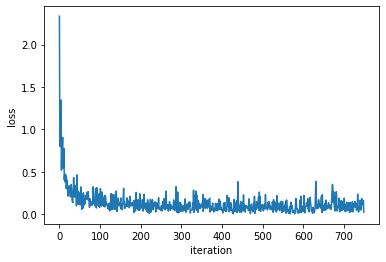

In [37]:
for epoch in range(1):
  model.train() # switching to training mode
  for iteration, batch in enumerate(dataloader_train):
      batch_inputs = {k: v.cuda(device) for k, v in list(batch[0].items())}
      batch_labels = batch[1].cuda(device)

      output = model(**batch_inputs)
      loss = CELoss(output.view(-1, output.size(-1)), batch_labels.view(-1))

      optimizer.zero_grad()
      loss.backward()

      optimizer.step()

      draw.append(loss.item())
      if (iteration + 1) % 30 == 0:
          print(f'{iteration:3} - loss: {loss.item()}')
  print("epoch{}: 완료\n".format(epoch + 1))
plt.plot(draw)
plt.xlabel("iteration")
plt.ylabel("loss")

# Test

loss: 0.03213406726717949
loss: 0.1102798655629158
loss: 0.050900187343358994
loss: 0.061525821685791016
loss: 0.05499173700809479
loss: 0.009833071380853653
loss: 0.027206378057599068
loss: 0.1526588350534439
loss: 0.06235317513346672
loss: 0.21791265904903412
loss: 0.14266817271709442
loss: 0.11661019176244736
loss: 0.027788203209638596
loss: 0.08564025908708572
loss: 0.04072168469429016
loss: 0.20184119045734406
loss: 0.034594133496284485
loss: 0.04128256440162659
loss: 0.12114536017179489
loss: 0.2627415359020233
loss: 0.19398175179958344
loss: 0.1817849725484848
loss: 0.12306004017591476
loss: 0.43966323137283325
loss: 0.29218852519989014
loss: 0.39662450551986694
loss: 0.5120947957038879
loss: 0.7202167510986328
loss: 0.0851563811302185
loss: 0.3585033416748047
loss: 0.0034823676105588675
loss: 0.17141485214233398
loss: 0.01602230593562126
loss: 0.1349472552537918
loss: 0.0017599128186702728
loss: 0.09973268955945969
loss: 0.14077702164649963
loss: 0.17448154091835022
loss: 0.118

Text(0, 0.5, 'loss')

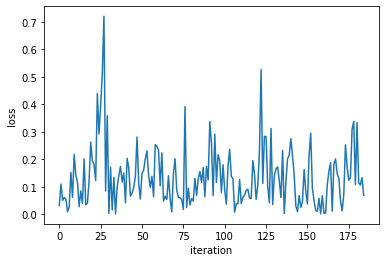

In [38]:
model.eval() # switching to evalutating mode: a function that turns off layers that should not be used in the evaluation process.

gold_list = [] # true
pred_list = []
draw_test = []

with torch.no_grad():
    for iteration, batch in enumerate(dataloader_test):
        batch_inputs = {k: v.cuda(device) for k, v in list(batch[0].items())}
        batch_labels = batch[1].cuda(device)

        output = model(**batch_inputs)

        loss = CELoss(output.view(-1, output.size(-1)), batch_labels.view(-1))

        print('loss:', loss.item())
        draw_test.append(loss.item())

        pred_ids = torch.argmax(output, dim = -1)
        
        for g, p in zip(batch_labels, pred_ids):
            gold_mask = g != 0
            
            gold = convert_id_to_tag_list(g[gold_mask].tolist())
            pred = convert_id_to_tag_list(p[gold_mask].tolist())
            gold_list.append(gold)
            pred_list.append(pred)
            
            # print(gold)
            # print(pred)
plt.plot(draw_test)
plt.xlabel("iteration")
plt.ylabel("loss")

In [39]:
gold_list_flat = []
pred_list_flat = []
for g, p in zip(gold_list, pred_list):
    gold_list_flat += g
    pred_list_flat += p

In [40]:
tag_to_id = {'I-LOC': 0, 'I-PER': 2, 'B-PER': 3, 'B-MISC': 4, 'I-ORG': 5, 'B-ORG': 6, 'I-MISC': 7, 'B-LOC': 8, 'PAD': 9}

In [41]:
print(classification_report(gold_list_flat, pred_list_flat, digits=5, labels=list(tag_to_id.keys())[1:]))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       I-PER    0.94101   0.95662   0.94875      3435
       B-PER    0.90866   0.94743   0.92764      1617
      B-MISC    0.74763   0.78490   0.76581       702
       I-ORG    0.93476   0.84580   0.88805      2795
       B-ORG    0.91667   0.82119   0.86631      1661
      I-MISC    0.51810   0.59785   0.55512       838
       B-LOC    0.90694   0.91727   0.91207      1668
         PAD    0.00000   0.00000   0.00000         0

   micro avg    0.88416   0.87512   0.87961     12716
   macro avg    0.73422   0.73388   0.73297     12716
weighted avg    0.88933   0.87512   0.88111     12716



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [42]:
from sklearn.metrics import accuracy_score
accuracy_score(gold_list_flat, pred_list_flat)

0.9659912708273599